In [1]:
params_rf = None
params_svm = None

svm or rf choose   svm


[I 2021-07-06 23:03:19,909] A new study created in memory with name: no-name-06734649-216a-4e87-9a24-b1f3d05d8744
[I 2021-07-06 23:03:22,762] Trial 0 finished with value: 0.874008568372454 and parameters: {'C': 16.66580868005156, 'gamma': 0.003276120233971992}. Best is trial 0 with value: 0.874008568372454.
[I 2021-07-06 23:03:24,754] Trial 1 finished with value: 0.6944065650670855 and parameters: {'C': 6.372234849987546, 'gamma': 0.0698506538861663}. Best is trial 0 with value: 0.874008568372454.
[I 2021-07-06 23:03:28,265] Trial 2 finished with value: 0.8099372248564644 and parameters: {'C': 19.22027021399147, 'gamma': 0.020775101159575166}. Best is trial 0 with value: 0.874008568372454.
[I 2021-07-06 23:03:30,424] Trial 3 finished with value: 0.666078727680815 and parameters: {'C': 9.909685489112315, 'gamma': 0.08438274795999373}. Best is trial 0 with value: 0.874008568372454.
[I 2021-07-06 23:03:32,306] Trial 4 finished with value: 0.846097325348612 and parameters: {'C': 2.86465723

[0.91833743 0.92081572 0.91848077 0.92249904 0.9236727  0.92646827]
[0.86589731 0.85518722 0.88888281 0.8626926  0.86648897 0.84637996]
[0.87911212 0.87584253 0.87504448 0.87278234 0.87719004 0.8786307 ]


AttributeError: 'SVR' object has no attribute 'predict_proba'

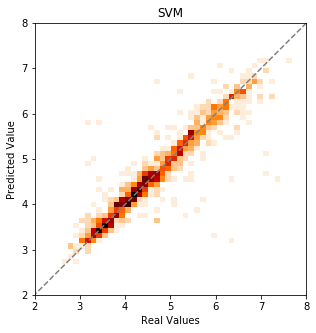

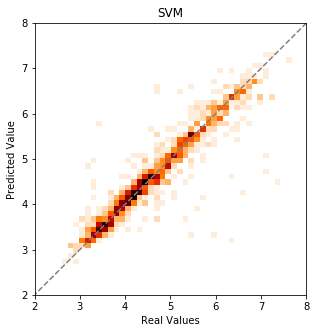

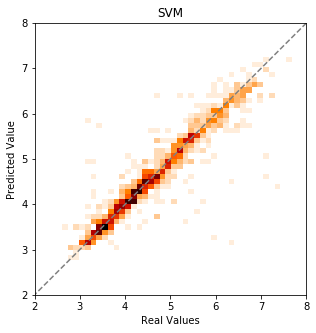

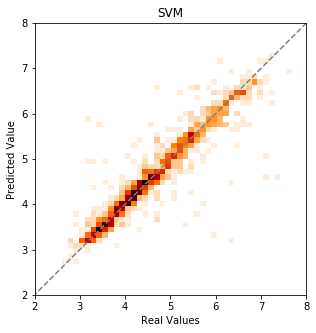

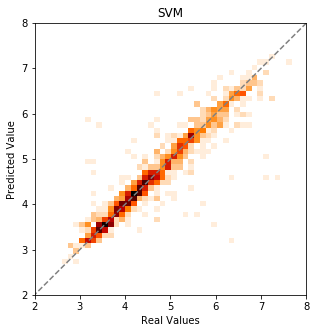

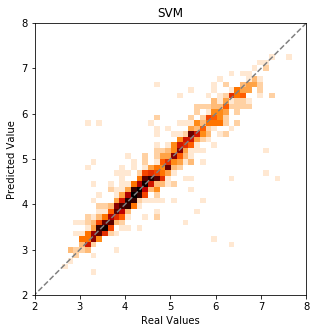

In [11]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np 
from ipykernel import kernelapp as app
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import optuna
import sklearn
from sklearn import datasets
from sklearn.svm import SVR
import optuna 
from optkeras.optkeras import OptKeras
import optkeras
import shap

df = pd.read_csv('10data.csv')
data = df.values
X_features = data[:,0:-1]
Y_properties = data[:,-1]

# standard
mean = Y_properties.mean()
scale = 10**int(np.log10(mean))
Y_properties /= scale
mean = Y_properties.mean()
std = Y_properties.std()
Zs = (Y_properties-mean)/std
mask = (Zs<3) & (Zs>-3)

X_features = X_features[mask.ravel(),:]
Y_properties = Y_properties[mask].ravel()

a10 = ['Al','As','B','Ba','Bi','Cd','Cu','Dy','Er','Fe','Ga','Gd','Ge','In','K','La','Mn','Na','P','Pb','Pr','S','Sb','Se','Si','Sn','Tb','Te','Tl','Xe','Zn']
X = pd.DataFrame(data = X_features,columns = a10)
Y = pd.DataFrame(data = Y_properties, columns = ['Tg'])

X_tr,X_shap,Y_tr,Y_shap = train_test_split(X,Y,test_size=0.2, random_state=33)
X_train,X_test,Y_train,Y_test = train_test_split(X_features,Y_properties,test_size=0.2, random_state=33)

kfold = KFold(n_splits=6, shuffle=True,random_state=42)

model = input('svm or rf choose   ')

if (model == 'rf'):

    def objective(trial):
        max_depth = trial.suggest_int("max_depth", 2, 32)
        list_trees = [10,15,25, 50,75,100,125,150,175,200]
        n_estimators = trial.suggest_categorical('n_estimators', list_trees)
        max_features = trial.suggest_uniform('max_features', 0.15, 1.0)
#         min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 14)
#         max_samples = trial.suggest_uniform('max_samples', 0.6, 0.99)
        
        
        classifier_obj = RandomForestRegressor(n_estimators= n_estimators,
                                         max_features= max_features,
#                                            min_samples_split=rf_min_samples_split,
                                           min_samples_leaf=min_samples_leaf, 
                                           max_depth= max_depth, bootstrap=True, n_jobs=-1, verbose=0)
    
        mean_cv_score = cross_val_score(classifier_obj, X_train,Y_train, scoring='r2',cv=kfold, n_jobs=-1).mean()
        return mean_cv_score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials= 5)
    # print('Number of finished trials:', len(study.trials))
    # print('Best trial:', study.best_trial.params)
    params = study.best_trial.params
    params_rf = params
    

    cvscores_rf = []
    scores_train_rf = []
    scores_test_rf = []
    for train, test in kfold.split(X_train, Y_train):
        np.random.seed(5)
        model_rf = RandomForestRegressor(**params)
        model_rf.fit(X_train[train],Y_train[train])
        scores2 = r2_score(model_rf.predict(X_train[train]),Y_train[train])
    
        scores = r2_score(model_rf.predict(X_train[test]),Y_train[test])
    
        y_test_pred = model_rf.predict(X_test)
        scores3 = r2_score(model_rf.predict(X_test),Y_test)
    
    #     print(model_rf.get_params)
        scores_train_rf.append(scores2)
        cvscores_rf.append(scores)
        scores_test_rf.append(scores3)
    
    
        heatmap, xedges, yedges = np.histogram2d(Y_test, y_test_pred, bins=40,density=1)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        from matplotlib import cm
        from matplotlib.colors import ListedColormap
        ocean = cm.get_cmap('gist_heat', 256)
        c_data = ocean(np.linspace(0, 1, 256))
        mycm = ListedColormap(c_data[::-1,:])
        plt.figure(figsize=(5,5))
        plt.clf()
        plt.plot(np.arange(9), np.arange(9), color='grey', linestyle='dashed')
        plt.imshow(heatmap.T, extent=extent, origin='lower',cmap = mycm)
        plt.xlim(2,8)
        plt.ylim(2,8)
        plt.xlabel("Real Values")
        plt.ylabel("Predicted Value")
        plt.title("Random Forest")
        plt.show()
            
    
    print(np.array(scores_train_rf))
    print(np.array(cvscores_rf))
    print(np.array(scores_test_rf))
    
    shap.initjs()
    explainer = shap.TreeExplainer(model_rf)
    shap_values = explainer.shap_values(X_shap)
    
    shap.summary_plot(shap_values, X_shap)
    
    
    
    top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

        # make SHAP plots of the three most important features
    for i in range(3):
        shap.dependence_plot(top_inds[i], shap_values, X_test)
        
    shap.initjs()    
    force = shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:])
    
if (model == 'svm'):
    
    def objective(trial):

        C = trial.suggest_uniform('C', 0.01, 20)
        gamma = trial.suggest_uniform('gamma', 0.0001,0.1)
        
        modelsv = SVR(kernel='rbf', C=C, gamma= gamma)

        mean_cv_scoresv = cross_val_score(modelsv, X_train,Y_train, scoring='r2', 
                                        cv=kfold, n_jobs=-1).mean()
        return mean_cv_scoresv
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials= 5)
    # print('Number of finished trials:', len(study.trials))
    # print('Best trial:', study.best_trial.params)
    params = study.best_trial.params
    params_svm = params
    
    cvscores = []
    scores_train = []
    scores_test = []
    for train, test in kfold.split(X_train, Y_train):
        np.random.seed(5)
        model = SVR(**params)
        model.fit(X_train[train],Y_train[train])
        scores2 = r2_score(model.predict(X_train[train]),Y_train[train])
    
        scores = r2_score(model.predict(X_train[test]),Y_train[test])
    
        y_test_pred = model.predict(X_test)
        scores3 = r2_score(model.predict(X_test),Y_test)
    
    #     print(model_rf.get_params)
        scores_train.append(scores2)
        cvscores.append(scores)
        scores_test.append(scores3)
        
    
    
    
        heatmap, xedges, yedges = np.histogram2d(Y_test, y_test_pred, bins=40,density=1)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        from matplotlib import cm
        from matplotlib.colors import ListedColormap
        ocean = cm.get_cmap('gist_heat', 256)
        c_data = ocean(np.linspace(0, 1, 256))
        mycm = ListedColormap(c_data[::-1,:])
        plt.figure(figsize=(5,5))
        plt.clf()
        plt.plot(np.arange(9), np.arange(9), color='grey', linestyle='dashed')
        plt.imshow(heatmap.T, extent=extent, origin='lower',cmap = mycm)
        plt.xlim(2,8)
        plt.ylim(2,8)
        plt.xlabel("Real Values")
        plt.ylabel("Predicted Value")
        plt.title("SVM")


    
    
    print(np.array(scores_train))
    print(np.array(cvscores))
    print(np.array(scores_test))
    
    
    explainer = shap.KernelExplainer(model.predict_proba, X_tr)
    shap_values = explainer.shap_values(X_shap)
    
    shap.summary_plot(shap_values, X_shap)
    
    
    
    top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

        # make SHAP plots of the three most important features
    for i in range(3):
        shap.dependence_plot(top_inds[i], shap_values, X_test)
        
    shap.initjs()    
    force = shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:])
    
    
force 